In [14]:
import pandas as pd
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from transformers import AutoTokenizer, AutoModel

df = pd.read_pickle('df.pkl')
df['report'] = df['PNT_NM'] + df['QUALIFIER_TXT'] + df['PNT_ATRISKNOTES_TX'] + df['PNT_ATRISKFOLWUPNTS_TX']

# Assuming df is your DataFrame
reports = df['report'].values
ovr_danger = df['ovr_danger'].values

In [15]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2' 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [16]:

def get_embeddings(reports):
    inputs = tokenizer(reports.tolist(), padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state[:, 0, :]  # Use the [CLS] token representation
    return embeddings.numpy()

embeddings = get_embeddings(reports)

In [17]:
tsne = TSNE(n_components=2, random_state=42)
embedded_2d = tsne.fit_transform(embeddings)

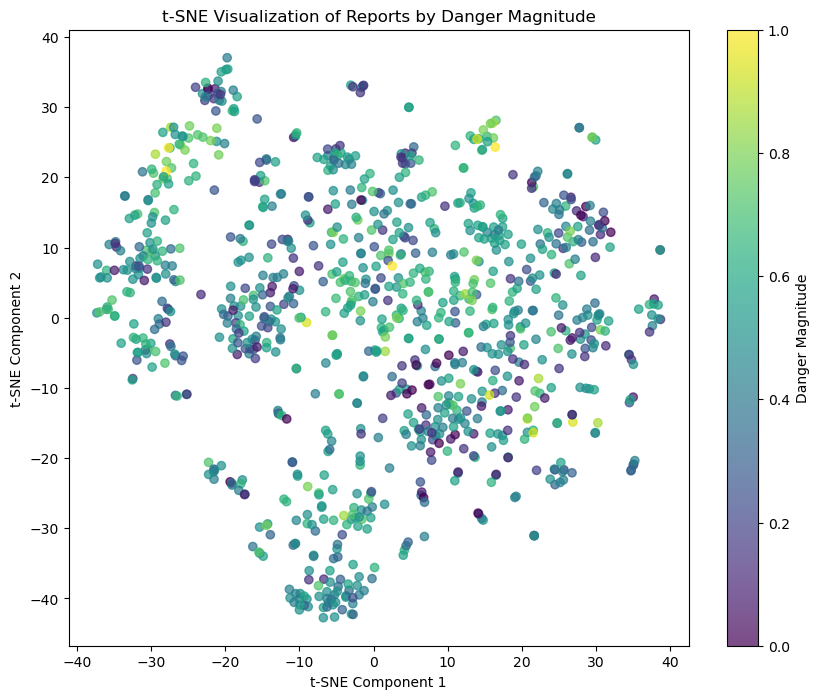

In [18]:
plt.figure(figsize=(10, 8))
#cmap = mcolors.LinearSegmentedColormap.from_list('red_green', ['green', 'yellow', 'red'])
scatter = plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], c=ovr_danger, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Danger Magnitude')
plt.title('t-SNE Visualization of Reports by Danger Magnitude')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [19]:
tsne = TSNE(n_components=3, random_state=42)  # Set n_components to 3 for 3D
embedded_3d = tsne.fit_transform(embeddings)

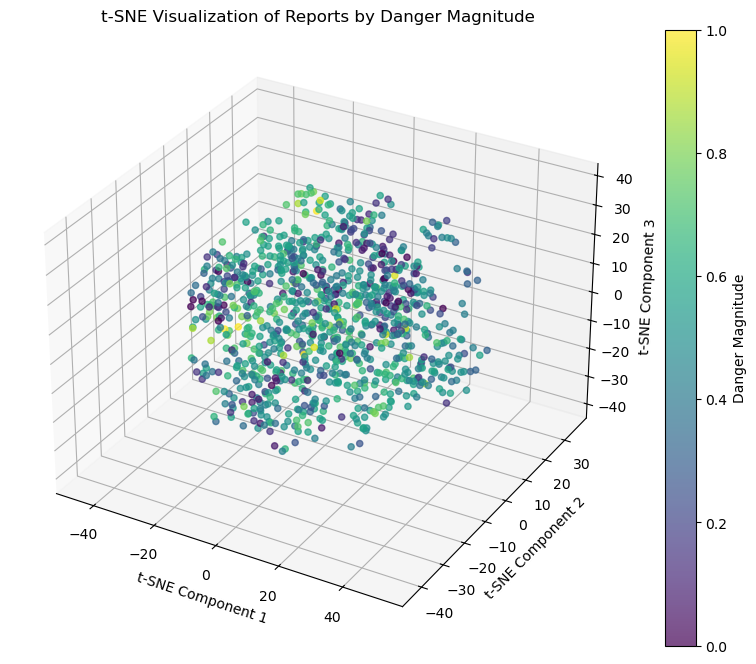

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedded_3d[:, 0], embedded_3d[:, 1], embedded_3d[:, 2], c=ovr_danger, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Danger Magnitude')
ax.set_title('t-SNE Visualization of Reports by Danger Magnitude')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()

/Users/jacktaylor2/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


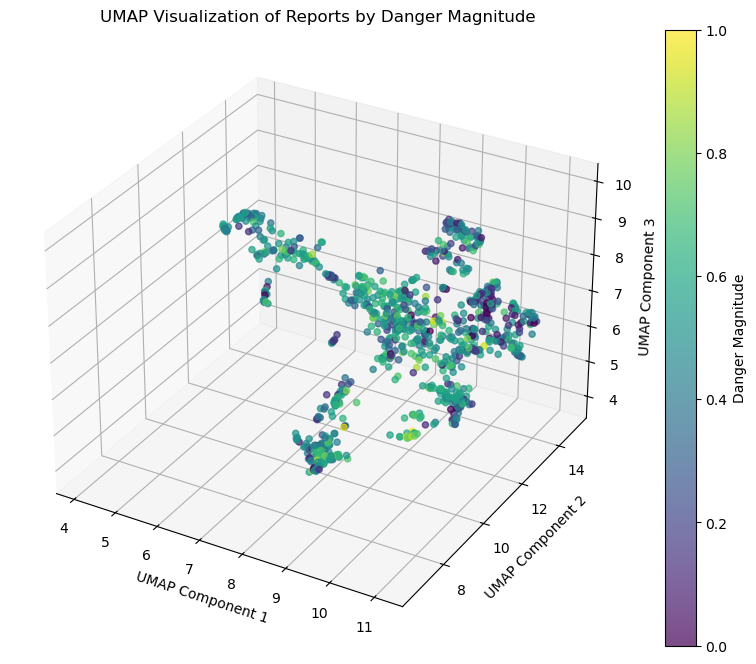

In [21]:
import umap

umap_model = umap.UMAP(n_components=3, random_state=42)
embedded_3d = umap_model.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedded_3d[:, 0], embedded_3d[:, 1], embedded_3d[:, 2], c=ovr_danger, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Danger Magnitude')
ax.set_title('UMAP Visualization of Reports by Danger Magnitude')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
plt.show()

09:16:37 - cmdstanpy - INFO - Chain [1] start processing
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
09:16:37 - cmdstanpy - INFO - Chain [1] done processing


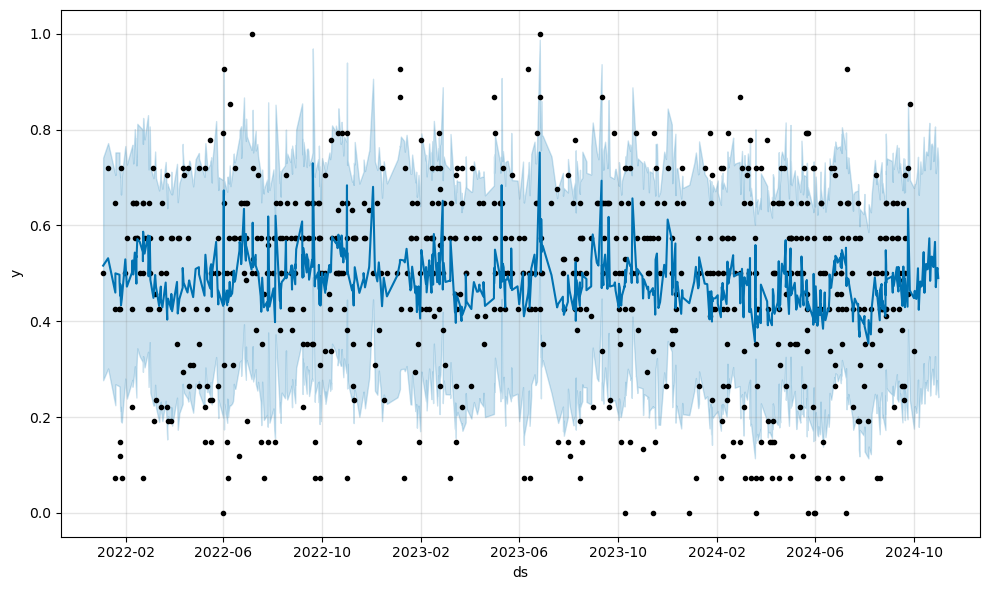

In [22]:
from prophet import Prophet
import pandas as pd

df = pd.read_pickle('df.pkl')

df['ds'] = pd.to_datetime(df['DATETIME_DTM'], format='%Y-%m-%d')
df.rename({'ovr_danger': 'y'}, axis=1, inplace=True)
#df = df[['ds', 'y']][::5]
df = df[df['ds'] >= '2022-01-01']

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=30)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

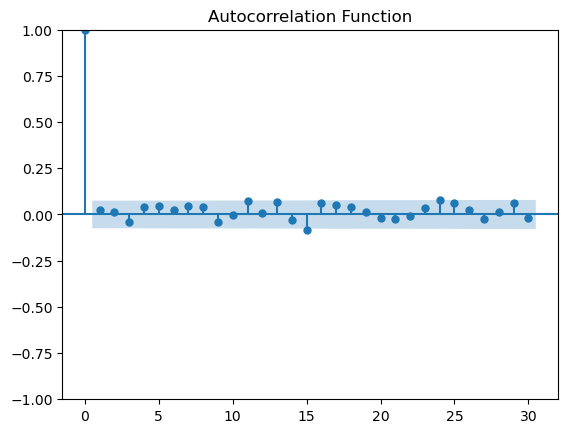

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['y'], lags=30)
plt.title('Autocorrelation Function')
plt.show()

Duplicate dates: DatetimeIndex(['2024-06-10 09:30:00', '2024-08-26 12:15:00',
               '2022-11-08 14:30:00', '2024-02-13 11:30:00',
               '2022-06-30 10:30:00', '2024-05-21 09:30:00'],
              dtype='datetime64[ns]', name='ds', freq=None)


/var/folders/1h/mw4kschx1jjdmd14bjl9nv4r0000gn/T/ipykernel_28449/21951988.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y'] = df['y'].fillna(method='ffill')


<Figure size 1200x600 with 0 Axes>

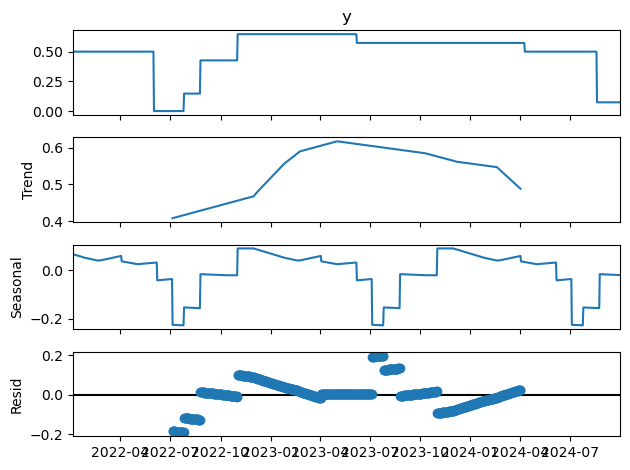

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose


df.set_index('ds', inplace=True)

duplicate_dates = df.index[df.index.duplicated()]
if not duplicate_dates.empty:
    print("Duplicate dates:", duplicate_dates)
    df = df[~df.index.duplicated(keep='first')]

df = df.asfreq('D')  

df['y'] = df['y'].fillna(method='ffill')  

# Decompose the time series
plt.figure(figsize=(12, 6))
decomposition = seasonal_decompose(df['y'], model='additive', period=365)  
decomposition.plot()
plt.show()

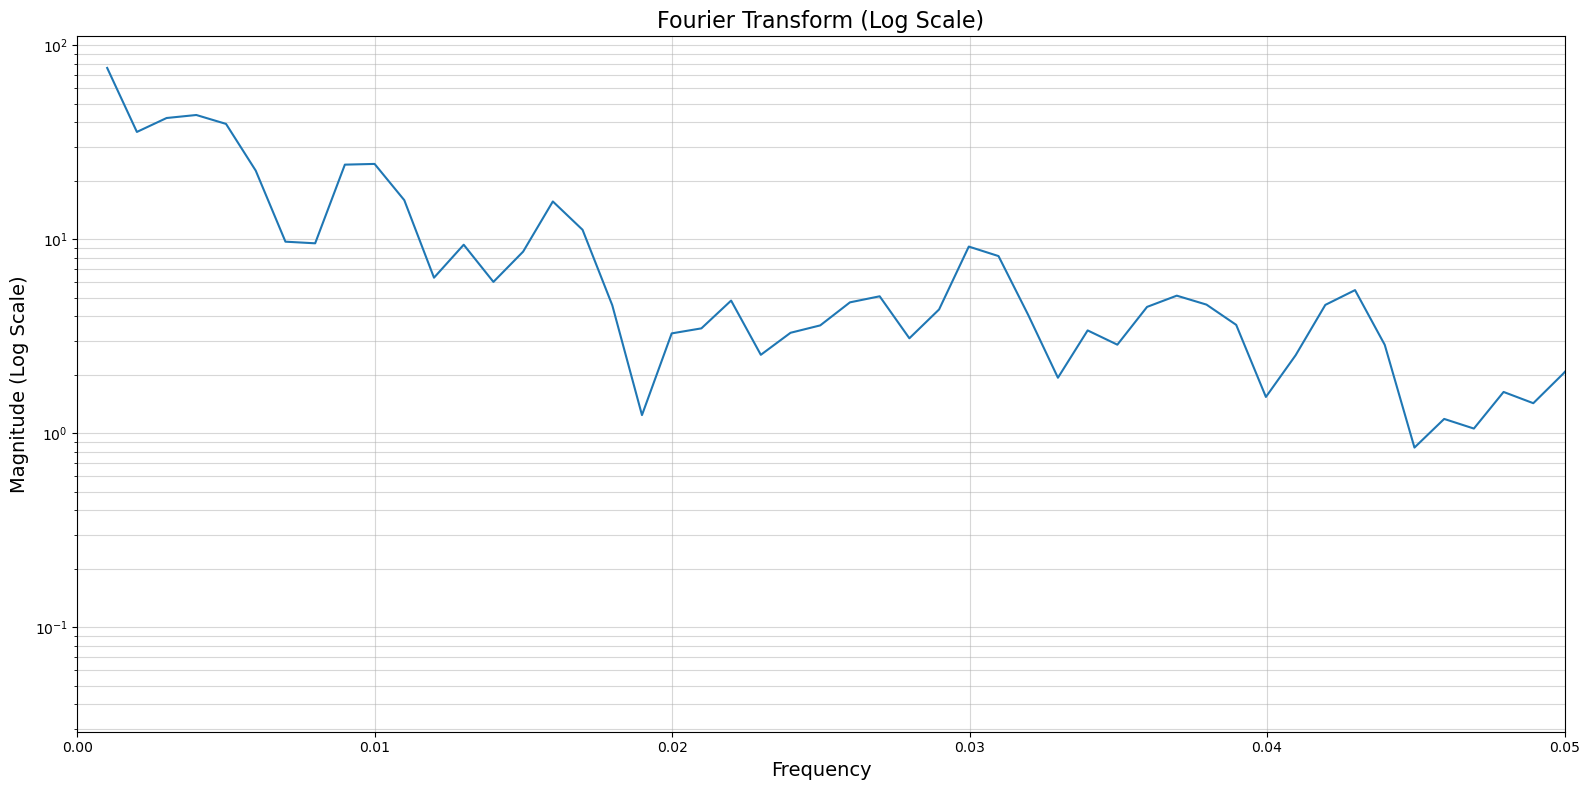

In [25]:
# Take the Fourier Transform of the data
fft_values = np.fft.fft(df['y'])
fft_freq = np.fft.fftfreq(len(fft_values))
n = len(fft_values)
positive_freq = fft_freq[:n//2]
magnitudes = np.abs(fft_values[:n//2])

plt.figure(figsize=(16, 8))
plt.semilogy(positive_freq[1:], magnitudes[1:]) 
plt.title('Fourier Transform (Log Scale)', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Magnitude (Log Scale)', fontsize=14)
plt.xlim(0, 0.05) 
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()